In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torchvision, torch

In [3]:
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob

In [16]:
dmerge = datasets.get_data("pc")

PC_Dataset num_samples=91658 views=['PA'] data_aug=None


In [5]:
#dmerge = datasets.get_data("chex")

In [6]:
#dmerge_full = datasets.get_data("chex", size=500)

In [7]:
# dataset_dir = "/home/groups/akshaysc/joecohen/"
# transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),
#                                                 xrv.datasets.XRayResizer(224)])
# dmerge = xrv.datasets.CheX_Dataset(
#     imgpath=dataset_dir + "/CheXpert-v1.0-small",
#     csvpath=dataset_dir + "/CheXpert-v1.0-small/train.csv",
#     transform=transform, unique_patients=False)

In [8]:
# dmerge = xrv.datasets.SubsetDataset(dmerge, np.where(np.nansum(dmerge.labels, axis=1) == 1)[0])

In [9]:
dmerge

{'Air Trapping': {0.0: 88285, 1.0: 3373},
 'Aortic Atheromatosis': {0.0: 90074, 1.0: 1584},
 'Aortic Elongation': {0.0: 84053, 1.0: 7605},
 'Atelectasis': {0.0: 87677, 1.0: 3981},
 'Bronchiectasis': {0.0: 90163, 1.0: 1495},
 'Cardiomegaly': {0.0: 83238, 1.0: 8420},
 'Consolidation': {0.0: 90661, 1.0: 997},
 'Costophrenic Angle Blunting': {0.0: 88178, 1.0: 3480},
 'Edema': {0.0: 91461, 1.0: 197},
 'Effusion': {0.0: 88316, 1.0: 3342},
 'Emphysema': {0.0: 90745, 1.0: 913},
 'Fibrosis': {0.0: 90985, 1.0: 673},
 'Flattened Diaphragm': {0.0: 91124, 1.0: 534},
 'Fracture': {0.0: 89051, 1.0: 2607},
 'Granuloma': {0.0: 89217, 1.0: 2441},
 'Hemidiaphragm Elevation': {0.0: 90294, 1.0: 1364},
 'Hernia': {0.0: 90177, 1.0: 1481},
 'Hilar Enlargement': {0.0: 87570, 1.0: 4088},
 'Infiltration': {0.0: 83915, 1.0: 7743},
 'Mass': {0.0: 90852, 1.0: 806},
 'Nodule': {0.0: 88001, 1.0: 3657},
 'Pleural_Thickening': {0.0: 88463, 1.0: 3195},
 'Pneumonia': {0.0: 88255, 1.0: 3403},
 'Pneumothorax': {0.0: 91435,

PC_Dataset num_samples=91658 views=['PA'] data_aug=None

In [5]:
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [6]:
models = [xrv.models.DenseNet(weights="all").cuda(),
          xrv.models.DenseNet(weights="mimic_ch").cuda(),
          xrv.baseline_models.jfhealthcare.DenseNet().cuda()]

In [7]:
model = models[0]
print(model.pathologies)
print(model)

['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
XRV-DenseNet121-all


In [8]:
for_eval = [
            "Cardiomegaly",
            "Atelectasis",
            "Effusion",
            "Consolidation",
            "Edema",
            "Mass"
#            "Pneumothorax",
            ]

In [9]:
model.pathologies

['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']

In [10]:
# print(target)
# idx = 50
# sample = dmerge[dwhere[idx]]
# csv = dmerge.csv.iloc[[dwhere[idx]]]
# image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

In [17]:
dmerge.pathologies

['Air Trapping',
 'Aortic Atheromatosis',
 'Aortic Elongation',
 'Atelectasis',
 'Bronchiectasis',
 'Cardiomegaly',
 'Consolidation',
 'Costophrenic Angle Blunting',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Flattened Diaphragm',
 'Fracture',
 'Granuloma',
 'Hemidiaphragm Elevation',
 'Hernia',
 'Hilar Enlargement',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax',
 'Scoliosis',
 'Support Devices',
 'Tuberculosis']

In [11]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation', 'Edema', 'Mass']

In [12]:
# target = "Effusion"
# label = 1
# dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]
# dwhere[:10]

In [13]:
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
folder = "images/"
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"

In [18]:
label = 1

for dname in ["pc", "chex"]:

    dmerge = datasets.get_data(dname)
    dmerge_large = datasets.get_data(dname, size=500)

    for target in for_eval:
        print(target)
        num_to_generate = 5

        if not (target in dmerge.pathologies):
            continue
            
        dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]
        np.random.seed(0)
        for idx in np.random.choice(range(len(dwhere)), 200):

            if num_to_generate == 0:
                break
            
            metadata = {}
            sample = dmerge[dwhere[idx]]
            csv = dmerge.csv.iloc[[dwhere[idx]]]
            image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

            p = model(image)[:,model.pathologies.index(target)].detach().cpu()
            print(p)

            #if ((label == 1) and p > 0.6) or ((label == 0) and p > 0.5):
            if p > 0.6:    
                
                num_to_generate-= 1
                
                #fname = csv.Path.str.replace("/","_").str.replace(".jpg","").max()
                fname = csv.patientid.max()
                fid = dmerge.__class__.__name__ + "-" + fname + "-" + target + "-" + str(label)
                basefname = folder + fid

                json_name = basefname + ".json"
                if (os.path.exists(json_name)):
                    print("already computed")
                    continue
                
                metadata = {}
                metadata["id"] = fid
                metadata["dataset"] = dmerge.__class__.__name__
                metadata["source"] = json.loads(csv.max().to_json())
                metadata["target"] = target
                metadata["label"] = label
                metadata["model_used"] = str(model)
                metadata["pred"] = float(p.cpu().numpy())
                metadata["attribs"] = {}

                for i, method in enumerate(methods):

                    if method == "image":
                        image_full = dmerge_large[dwhere[idx]]["img"]
                        plt.imshow(image_full[0], interpolation='none', cmap="gray")
                        #plt.imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
                    else:
                        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
                        plt.imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
                        dimage[dimage==0] = np.nan
                        plt.imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");

                    plt.axis('off')
                    rfname = basefname + "-" + method + '.png'
                    print(rfname)
                    metadata["attribs"][method] = rfname
                    plt.savefig(rfname, bbox_inches='tight', pad_inches=0, transparent=False)


                fname = attribution.generate_video(image, model, target, ae, temp_path, 
                                           target_filename=basefname + "-latentshift", 
                                           border=False, show=False)
                metadata["attribs"]["latentshift"] = basefname + "-latentshift.mp4"

                with open(json_name, 'w') as outfile:
                    json.dump(metadata, outfile)


PC_Dataset num_samples=91658 views=['PA'] data_aug=None
PC_Dataset num_samples=91658 views=['PA'] data_aug=None
Cardiomegaly
tensor([0.6827])
already computed
tensor([0.4138])
tensor([0.7744])
already computed
tensor([0.5379])
tensor([0.5775])
tensor([0.5059])
tensor([0.8122])
already computed
tensor([0.9692])
already computed
tensor([0.0734])
tensor([0.6536])
already computed
Atelectasis
tensor([0.5210])
tensor([0.0878])
tensor([0.1616])
tensor([0.5071])
tensor([0.3226])
tensor([0.5405])
tensor([0.4159])
tensor([0.2588])
tensor([0.5249])
tensor([0.6448])
already computed
tensor([0.2774])
tensor([0.1631])
tensor([0.7181])
already computed
tensor([0.6249])
already computed
tensor([0.6768])
already computed
tensor([0.1111])
tensor([0.5047])
tensor([0.3902])
tensor([0.4343])
tensor([0.5364])
tensor([0.5326])
tensor([0.5070])
tensor([0.6201])
already computed
Effusion
tensor([0.8944])
already computed
tensor([0.6247])
already computed
tensor([0.6339])
already computed
tensor([0.8840])
alre

0

In [ ]:
# page = ""
# for target in for_eval:
#     for label in [1]:
#         if label == 1:
#             page += "<h2>{} - True Positive</h2>"
#         else:
#             page += "<h2>{} - False Positive</h2>"
#         page += "<h2>{} - Predicted {}</h2>".format(target, "Positive" if label == 1 else "Negative")
#         page += "<ol>"
#         for j in glob.glob("images/*{}-{}.json".format(target, label, )):
#             metadata = json.load(open(j))
#             print(metadata["id"])
#             #title = "{} - {} - {}".format(metadata["source"]["Sex"], metadata["source"]["Age"], metadata["id"])
#             title = "{} - {}".format(metadata["dataset"], metadata["id"])
#             link = "<li><a href='{}' target='viewer'>{}</a></li>".format("viewer.htm?img="+metadata["id"], title)
#             page += link
#         page += "</ol>"
# with open("list.htm", 'w') as f:
#     f.write(page)

In [123]:
metadata = json.load(open(j))

In [128]:
metadata

{'id': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1',
 'source': {'index': 16,
  'Path': 'CheXpert-v1.0-small/train/patient00009/study1/view1_frontal.jpg',
  'Sex': 'Male',
  'Age': 76,
  'Frontal/Lateral': 'Frontal',
  'AP/PA': 'PA',
  'No Finding': None,
  'Enlarged Cardiomediastinum': None,
  'Cardiomegaly': 1.0,
  'Lung Opacity': None,
  'Lung Lesion': None,
  'Edema': 0.0,
  'Consolidation': None,
  'Pneumonia': None,
  'Atelectasis': 1.0,
  'Pneumothorax': None,
  'Pleural Effusion': None,
  'Pleural Other': None,
  'Fracture': None,
  'Support Devices': None,
  'view': 'PA',
  'patientid': '00009'},
 'target': 'Cardiomegaly',
 'label': 1,
 'model_used': 'XRV-DenseNet121-all',
 'pred': 0.8785651922225952,
 'attribs': {'image': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1-image.png',
  'grad': 'images/CheXpert-v1.0-small_train_patient00009_study1_view1_frontal-Cardiomegaly-1-grad.png',
  'guided': 'images/

In [303]:
(image-100).clamp(-1024, 1024)

tensor([[[[ -993.1782,  -993.1913,  -993.1913,  ...,   100.8569,
             104.0126,   178.8278],
          [-1024.0000, -1024.0000, -1024.0000,  ...,  -596.5046,
            -582.4520,  -565.7678],
          [-1024.0000, -1024.0000, -1024.0000,  ...,  -970.1744,
            -971.8531,  -977.3716],
          ...,
          [ -895.7054,  -760.4562,  -663.6306,  ..., -1024.0000,
           -1024.0000, -1024.0000],
          [ -723.5236,  -534.2253,  -466.3681,  ..., -1024.0000,
           -1024.0000, -1024.0000],
          [ -288.1201,   -10.5599,    53.2822,  ..., -1014.6610,
           -1017.2435, -1016.8609]]]], device='cuda:0')

In [281]:
for_eval

['Cardiomegaly', 'Atelectasis', 'Effusion', 'Consolidation']

In [291]:
target = "Cardiomegaly"
label = 1
dwhere = np.where((dmerge.labels[:,dmerge.pathologies.index(target)]  == label))[0]
dwhere[:10]

array([  2,  21,  38,  39,  50,  51,  85,  87, 103, 105])

In [361]:
print(target)
idx = 15
sample = dmerge[dwhere[idx]]
csv = dmerge.csv.iloc[[dwhere[idx]]]
image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

Cardiomegaly


In [372]:
# img = skimage.filters.gaussian(sample["img"][0], 
#                         mode='constant', 
#                         sigma=(2, 2), 
#                         truncate=3.5)
# image = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).cuda()
# image = (image-100).clamp(-1024, 1024)

In [36]:
model = models[0]

[0.35955217] -110 4
0
10
20
module load ffmpeg;ffmpeg -loglevel quiet -stats -y -i /lscratch/joecohen/SDS-2342-ASDAA/image-%d-a.png -c:v libx264 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'


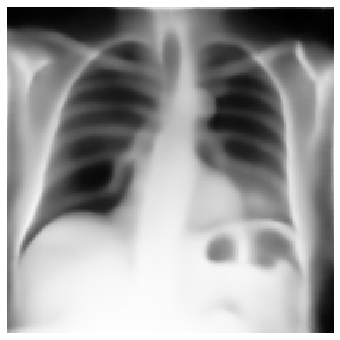

In [34]:
temp_path = "/lscratch/joecohen/SDS-2342-ASDAA"
attribution.generate_video(image, model, target, ae, temp_path, target_filename="test", border=False, show=True)

tensor([0.6395])
[0.5017618] -1000 340


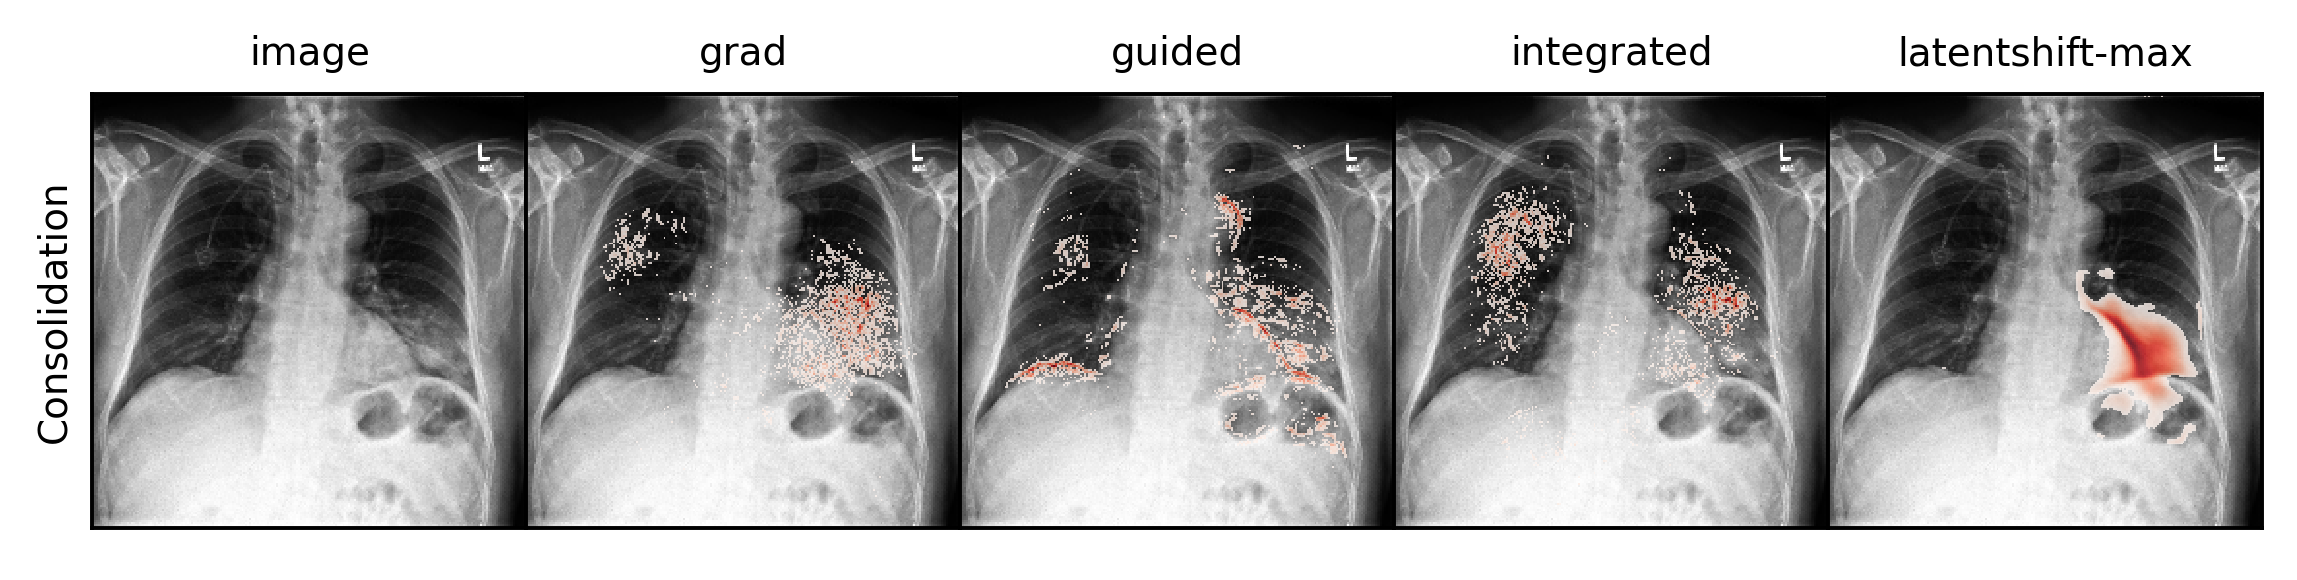

In [38]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.6395])
[0.5017618] -1000 340


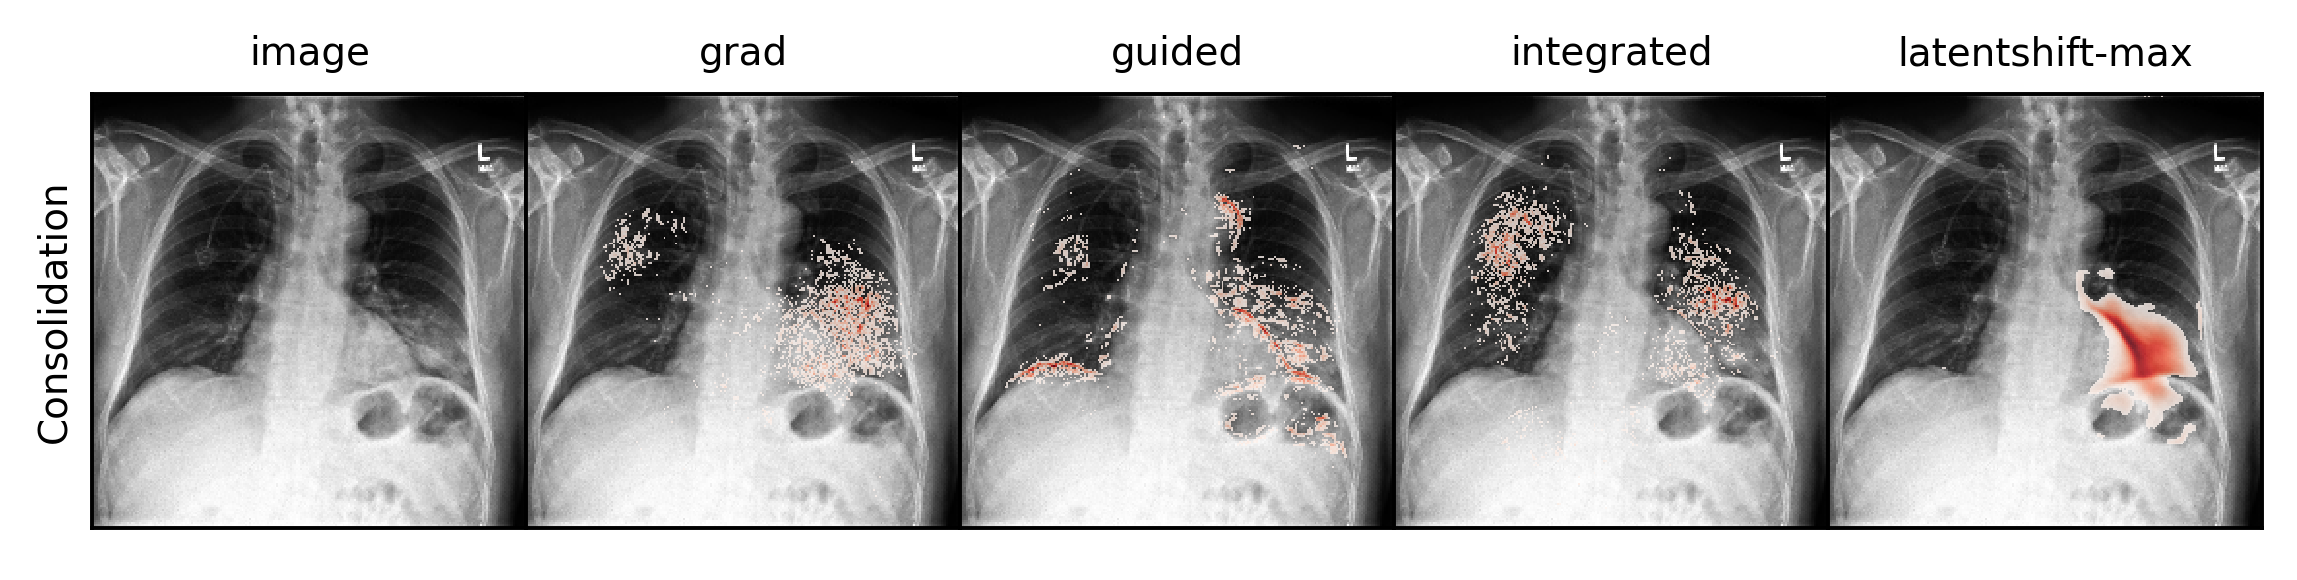

In [37]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.8695])
[0.35955217] -110 4


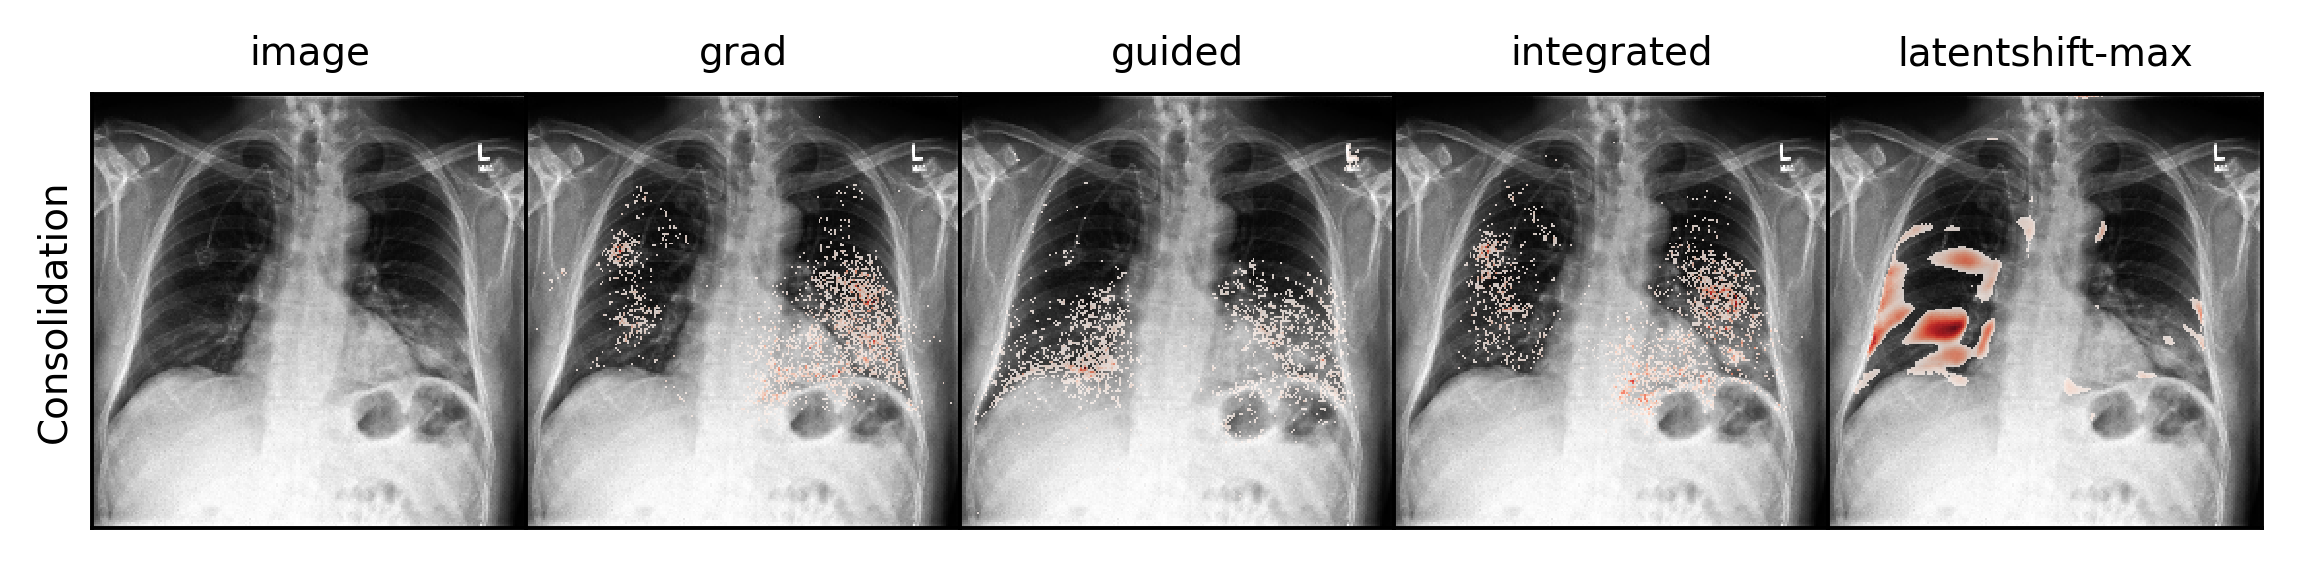

In [35]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);

tensor([0.8463])
[0.60260504] -150 10


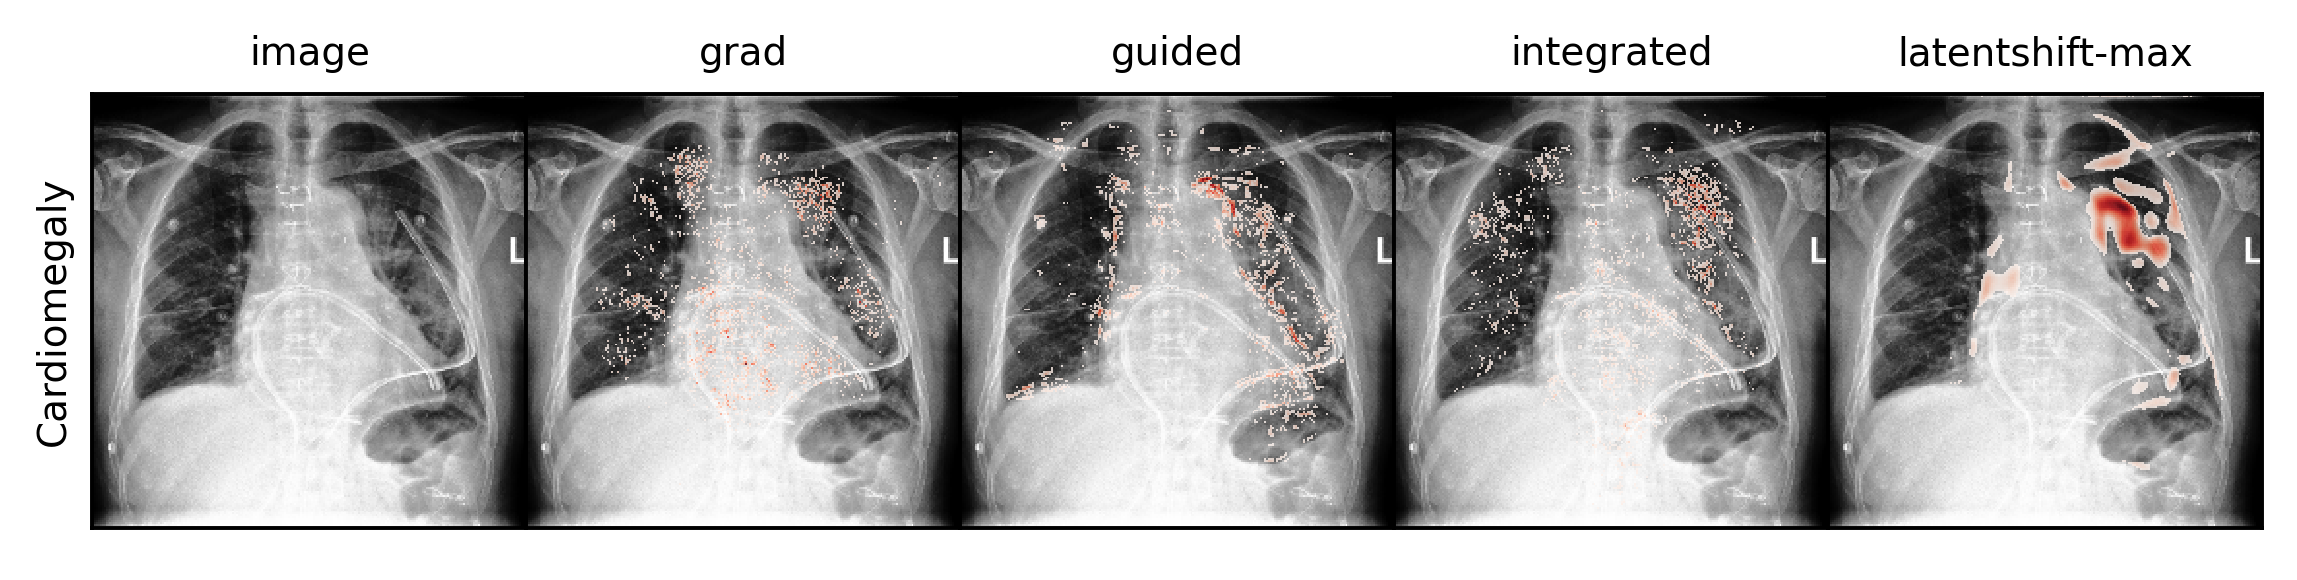

In [326]:
p = model(image)[:,model.pathologies.index(target)].detach().cpu()
print(p)
methods = ["image", "grad", "guided", "integrated", "latentshift-max"]
fig, ax = plt.subplots(1,len(methods), figsize=(8,3), dpi=350)
for i, method in enumerate(methods):
    
    if method == "image":
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        ax[i].set_ylabel(target, fontsize=8)
    else:
        dimage = attribution.compute_attribution(image, method, model, target, ae=ae, threshold=True)
        ax[i].imshow(image.detach().cpu()[0][0], interpolation='none', cmap="gray")
        dimage[dimage==0] = np.nan
        ax[i].imshow(dimage, interpolation='none', alpha=0.8, cmap="Reds");
    try:
        ax[i].imshow(sample["pathology_masks"][dmerge.pathologies.index(target)][0], interpolation='none', alpha=0.1);
    except:
        pass
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_yticks([])
    #ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(method, fontsize=8)
fig.subplots_adjust(wspace=0, hspace=0);